## Import modules, data and packages

In [15]:
import models.road_network.create_graph as cg
import models.vehicle_models.energy_consumption as ec
import simulation.simulate_routes as sr
import main as m
import json
import math
import pandas as pd
import random
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

Collect data, and config files

In [16]:
with open("./data_collection/data/test_data.json", "r") as file:
    complete_road_data = json.load(file)
with open("models/vehicle_models/static_data.json", "r") as file:
    static_data = json.load(file)
with open("models/vehicle_models/vehicle_data.json", "r") as file:
    vehicle_data = json.load(file)
with open("models/vehicle_models/battery_data.json", "r") as file:
    battery_data = json.load(file)

road_network_file = './data_collection/data/edge_data.csv' 
road_df = pd.read_csv(road_network_file)


Define key variables and compile graph

In [17]:
OCV = battery_data["OCV"]
capacity = battery_data["Capacity"]
R_int = battery_data["R_internal"]
motor_eff = vehicle_data["motor_eff"]

graph = cg.create_osmnx_compatible_graph(road_network_file)

## Analyse Route and Collect Data

In [18]:
with open("./data_collection/data/analysed_dis_data.json", "r") as file:
    map_data = json.load(file)

simulated_route_dict = sr.find_random_route(map_data,road_df, graph)
sim_dist, sim_consum, sim_climb = sr.return_route_data(simulated_route_dict, vehicle_data, static_data, motor_eff)

# fig, ax = cg.plot_graph_with_routes(graph,route)

print("---- Route Analysis ----")
print(f'Distance Travelled: {round(sim_dist,2)}m')
print(f'Energy Consumption: {round(sim_consum, 2)}Wh')
print(f'Overall Climb: {round(sim_climb,2)}m')

---- Route Analysis ----
Distance Travelled: 2071.3m
Energy Consumption: 112.55Wh
Overall Climb: -8.68m


Define test set.

In [19]:
test_set = [(2004050909, 5517369465), (1022548104, 6058290566), (26167344, 1970089908), (10935221495, 4765573944), (1970773874, 1692444892), (1692444945, 9944114380), (2472524829, 2700693002), (4117553202, 4150116222), (957754269, 10751398349), (4032728634, 26215513), (26215525, 1968626161), (26165148, 5519467268), (26070224, 6439781387), (4032728634, 26215516), (12106932177, 4117553241), (12106877513, 4416875033), (1968626170, 7737202755), (26215527, 1775501534), (6835942108, 1968626144), (1692444818, 5519467286), (26218282, 26070232), (826838268, 10935221426), (982935335, 21529979), (826838286, 4117553197), (2207401618, 11865591910), (2757541579, 2298696536), (430178844, 26070191), (1572010433, 26070233), (10794781025, 10935231459), (465205523, 26070207), (1692444818, 4414001238), (1775501535, 1968626115), (12106877508, 3460374403), (5499934242, 4117553207), (10739497719, 830599351), (10794781025, 242790325), (1775501535, 10935231430), (17585143, 26070238), (26190470, 981814755), (3683449012, 26165125), (21531985, 6071146268), (242790325, 3684809154), (26070196, 2004051104), (26104492, 6058981816), (11865591906, 10739447463), (26070196, 957754269), (3683449012, 5499934253), (5499934241, 830599395), (8265614352, 26104496), (10935221491, 10794808742), (5517369465, 5359649075), (26070198, 6071146263), (6835918884, 26070229), (4585717384, 26070224), (10935221491, 26167336), (430191112, 1130578185), (6071146258, 1022548134), (26070190, 2004051110), (26104404, 4117553193), (4117553193, 26070236), (1775501535, 1022548104), (10935231459, 10283016088), (1968626115, 853556892), (10935221495, 2757541600), (1692444946, 4117553193), (26190463, 974590436), (430191416, 26215512), (26070190, 1130578185), (826838286, 8265614352), (25991706, 1052953603), (982935335, 891026747), (4218233651, 26070229), (430672321, 1692444946), (1968626170, 1986278381), (26215527, 26218275), (26215522, 26070189), (957704261, 26070239), (367036281, 26165127), (10283016087, 7065555301), (26165128, 4117553235), (2004050909, 5499934253), (26070212, 2334411823), (4032728626, 10794808742), (1692444887, 26167336), (4117553207, 5517369464), (1130492591, 5499934229), (2004050917, 891026747), (2006482395, 2757541600), (3683449014, 17585265), (26070206, 430270406), (26218283, 10794781025), (21529973, 830599351), (1968626134, 1968626170), (4765573944, 4032728626), (17585267, 247900792), (430179935, 9568203077), (26190463, 10935221494), (10935231422, 26165135), (4117553202, 26070211), (830599319, 8265614349)]

Simulate routes for all test sets.

In [20]:
sim_results = {}
for points in test_set:
    # Get results for default weights
    route_output = sr.find_route(map_data, road_df, graph, points[0], points[1], weights_type='default')
    s_dist, s_cons, s_climb = sr.return_route_data(route_output, vehicle_data, static_data, motor_eff)
    
    # Initialize dictionary for this points pair
    sim_results[f'{points}'] = {"dist": s_dist, "climb": s_climb, "cons": s_cons}
    
    # Get results for random weights
    route_output = sr.find_route(map_data, road_df, graph, points[0], points[1], weights_type='random')
    r_dist, r_cons, r_climb = sr.return_route_data(route_output, vehicle_data, static_data, motor_eff)
    
    # Update the existing dictionary with the random results
    sim_results[f'{points}'].update({"r_dist": r_dist, "r_climb": r_climb, "r_cons": r_cons})

Plot the change consumption variables by changing weights from random to default.

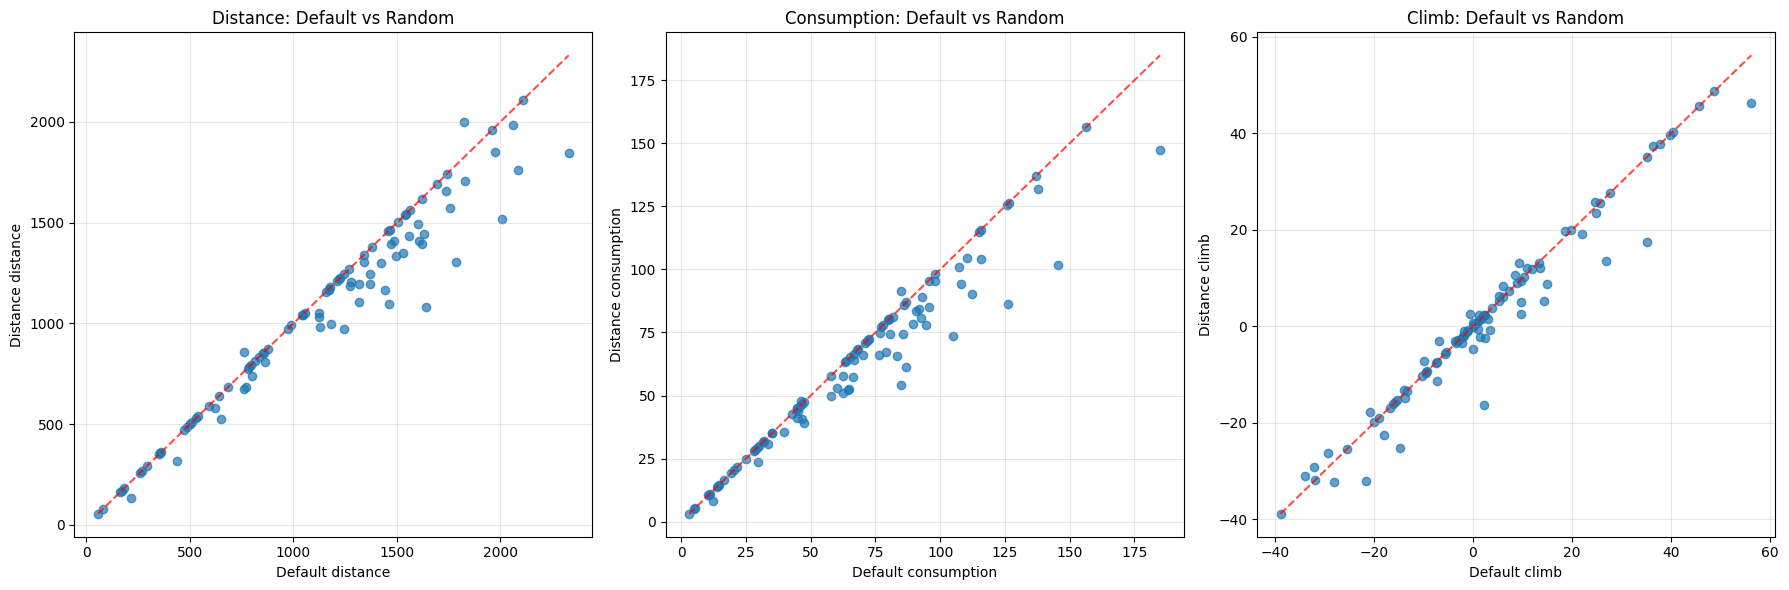

In [21]:
def plot_route_comparisons(sim_results):
    # Create a dataframe from the dictionary
    rows = []
    for route_key, metrics in sim_results.items():
        # Extract route id
        route_id = route_key
        
        # Create rows for comparison
        rows.append({
            'route_id': route_id,
            'metric': 'distance',
            'default': metrics['dist'],
            'random': metrics['r_dist'],
            'percent_change': (metrics['r_dist'] - metrics['dist']) / metrics['dist'] * 100
        })
        
        rows.append({
            'route_id': route_id,
            'metric': 'consumption',
            'default': metrics['cons'],
            'random': metrics['r_cons'],
            'percent_change': (metrics['r_cons'] - metrics['cons']) / metrics['cons'] * 100
        })
        
        rows.append({
            'route_id': route_id,
            'metric': 'climb',
            'default': metrics['climb'],
            'random': metrics['r_climb'],
            'percent_change': (metrics['r_climb'] - metrics['climb']) / metrics['climb'] * 100
        })
    
    df = pd.DataFrame(rows)
    
    # 1. Scatter Plots - Default vs Random for each metric
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics = ['distance', 'consumption', 'climb']
    for i, metric in enumerate(metrics):
        metric_df = df[df['metric'] == metric]
        
        axes[i].scatter(metric_df['default'], metric_df['random'], alpha=0.7)
        
        # Add reference line (y=x)
        min_val = min(metric_df['default'].min(), metric_df['random'].min())
        max_val = max(metric_df['default'].max(), metric_df['random'].max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
        
        axes[i].set_xlabel(f'Default {metric}')
        axes[i].set_ylabel(f'Distance {metric}')
        axes[i].set_title(f'{metric.capitalize()}: Default vs Random')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Example usage:
plot_route_comparisons(sim_results)